In [109]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

## Getting to Know the Data

In [110]:
# Loading data as pandas dataframe

# Naming the columns with attributes they represent
names = ['account_status', 'duration', 'credit_history',
             'purpose', 'credit_amount', 'savings_account', 'employment_since',
             'installment_rate', 'personal_status_sex', 'guarantors', 
             'residence_since', 'property', 'age', 'other_installment_plans',
             'housing', 'number_of_credits', 'job', 'people_to_maintain',
             'phone', 'foreign_worker', 'creditworthy']

df = pd.read_csv('data/kredit.dat', header=None, sep="\t", names=names)
# df = pd.read_csv('data/einkommen.train.txt', header=None, sep=",")
df.shape

(1000, 21)

In [111]:
# Last column is the target variable

label = df['creditworthy']
df = df.drop(columns=['creditworthy'])
df.shape

(1000, 20)

In [112]:
# Getting familiar with data

print(f'Number of data points: {df.shape[0]}')
print(f'Number of Attributes: {df.shape[1]}')
df.head(10)

Number of data points: 1000
Number of Attributes: 20


,account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,guarantors,residence_since,property,age,other_installment_plans,housing,number_of_credits,job,people_to_maintain,phone,foreign_worker
0,A14,36,A32,?,2299,A63,?,4,A93,A101,4,A123,39,A143,A152,1,A173,1,A191,?
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,4,A124,61,A143,A153,1,?,1,A191,A201
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,3,A124,38,A141,A153,1,?,2,A191,?
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,3,A121,33,A141,A152,2,A173,1,A191,A201
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,3,A123,34,A143,A152,1,A173,2,A192,A201
5,A12,24,A34,A40,3878,A62,?,4,A91,A101,2,A123,37,A143,A152,1,?,1,A192,A201
6,A14,24,A32,A41,6313,A65,A75,3,A93,A101,4,A123,41,A143,A152,1,A174,2,A192,A201
7,A11,21,A33,A46,3414,A61,?,2,A93,A101,1,A122,26,A143,A152,2,A173,1,A191,A201
8,A11,24,A34,A41,6419,A61,?,2,A92,A101,4,A124,44,A143,A153,2,A174,2,A192,A201
9,A12,18,A32,?,1924,A65,A72,4,A92,A101,3,A121,27,A143,A151,1,A173,1,A191,?


In [129]:
# Change a yes/no categorical varibable into numeric one
df.replace('A201', 1, inplace=True)
df.replace('A202', 0, inplace=True)

In [113]:
# For more convenient operations for missing values, replace ? with NaN
# As we see, there are too many missing values to remove these points from the dataset
df.replace("?", np.nan, inplace=True)
print(f'Number of Missing Values:\n\n{df.isnull().sum()}')

Number of Missing Values:

account_status               0
duration                     0
credit_history               0
purpose                    173
credit_amount                0
savings_account              0
employment_since           496
installment_rate             0
personal_status_sex          0
guarantors                   0
residence_since              0
property                     0
age                          0
other_installment_plans      0
housing                      0
number_of_credits            0
job                        232
people_to_maintain           0
phone                        0
foreign_worker             360
dtype: int64


In [115]:
df.head()

,account_status,duration,credit_history,purpose,credit_amount,savings_account,employment_since,installment_rate,personal_status_sex,guarantors,residence_since,property,age,other_installment_plans,housing,number_of_credits,job,people_to_maintain,phone,foreign_worker
0,A14,36,A32,NaN,2299,A63,NaN,4,A93,A101,4,A123,39,A143,A152,1,A173,1,A191,NaN
1,A12,18,A32,A46,1239,A65,A73,4,A93,A101,4,A124,61,A143,A153,1,NaN,1,A191,1.0
2,A13,24,A32,A40,947,A61,A74,4,A93,A101,3,A124,38,A141,A153,1,NaN,2,A191,NaN
3,A14,15,A33,A43,1478,A61,A73,4,A94,A101,3,A121,33,A141,A152,2,A173,1,A191,1.0
4,A14,24,A32,A40,1525,A64,A74,4,A92,A101,3,A123,34,A143,A152,1,A173,2,A192,1.0


In [116]:
# Show how many unique values we have: useful for one-hot encoding
df.nunique()

account_status               4
duration                    33
credit_history               5
purpose                     10
credit_amount              921
savings_account              5
employment_since             5
installment_rate             4
personal_status_sex          4
guarantors                   3
residence_since              4
property                     4
age                         53
other_installment_plans      3
housing                      3
number_of_credits            4
job                          4
people_to_maintain           2
phone                        2
foreign_worker               2
dtype: int64

In [117]:
df.dtypes

account_status              object
duration                     int64
credit_history              object
purpose                     object
credit_amount                int64
savings_account             object
employment_since            object
installment_rate             int64
personal_status_sex         object
guarantors                  object
residence_since              int64
property                    object
age                          int64
other_installment_plans     object
housing                     object
number_of_credits            int64
job                         object
people_to_maintain           int64
phone                       object
foreign_worker             float64
dtype: object

In [118]:
# As we see above: 2 data types
# Features will be treated separately

categorical = [att for att in df.columns if df[att].dtype == 'object']
numerical = [att for att in df.columns if df[att].dtype == 'int64']

print(f'Categorical features:\n{categorical}\n')
print(f'Numerical features:\n{numerical}')

Categorical features:
['account_status', 'credit_history', 'purpose', 'savings_account', 'employment_since', 'personal_status_sex', 'guarantors', 'property', 'other_installment_plans', 'housing', 'job', 'phone']

Numerical features:
['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'number_of_credits', 'people_to_maintain']


In [119]:
#Describing numerical values.
df.describe()

,duration,credit_amount,installment_rate,residence_since,age,number_of_credits,people_to_maintain,foreign_worker
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,640.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,0.957812
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.201174
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


In [120]:
# Categorical Features. These will have to be transformed
df.describe(exclude=[np.number]) 

,account_status,credit_history,purpose,savings_account,employment_since,personal_status_sex,guarantors,property,other_installment_plans,housing,job,phone
count,1000,1000,827,1000,504,1000,1000,1000,1000,1000,768,1000
unique,4,5,10,5,5,4,3,4,3,3,4,2
top,A14,A32,A43,A61,A73,A93,A101,A123,A143,A152,A173,A191
freq,394,530,226,603,157,548,907,332,814,713,484,596


1    700
2    300
Name: creditworthy, dtype: int64


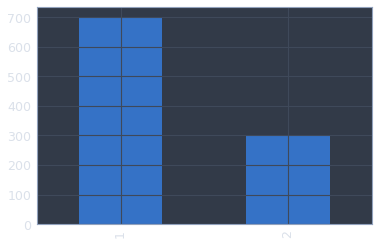

In [121]:
# How balanced is the dataset?
# 1 = yes
# 2 = no
print(label.value_counts())

label.value_counts().plot(kind='bar', label= 'Target Values')
# There are more than twice as many creditworthy examples

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1f4f4eb8>,
      dtype=object)

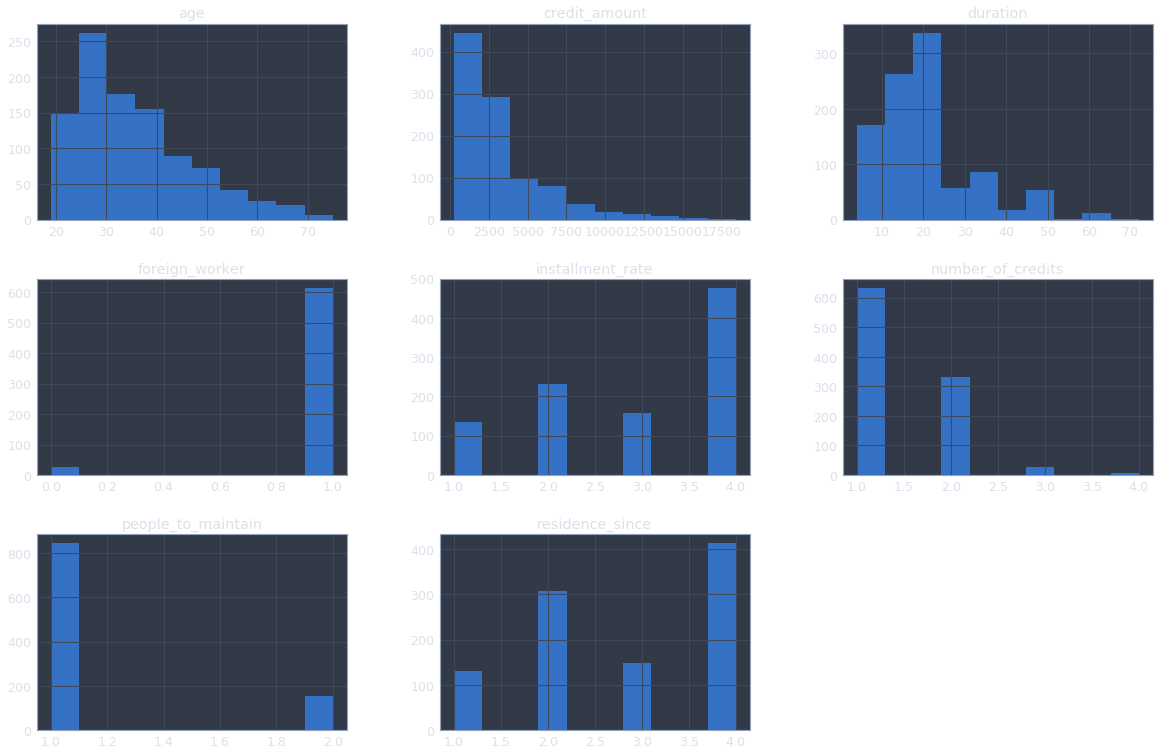

In [122]:
# As we see, the scales are very different, so we will have to normalize the data
df.hist(figsize = (20,13))


In [123]:
pd.crosstab(label, df['credit_history'])

credit_history,A30,A31,A32,A33,A34
creditworthy,,,,,
1,15,21,361,60,243
2,25,28,169,28,50


## 2. Data Pre-Processing

### 2.1 Feature Representation

#### 2.1.1 Numerical

In [124]:
# Ranges of values 
print()
for pos in range(len(numerical)):
    print(f'{numerical[pos]} : {df[numerical[pos]].min()} - {df[numerical[pos]].max()}')


duration : 4 - 72
credit_amount : 250 - 18424
installment_rate : 1 - 4
residence_since : 1 - 4
age : 19 - 75
number_of_credits : 1 - 4
people_to_maintain : 1 - 2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a20f2c080>,
      dtype=object)

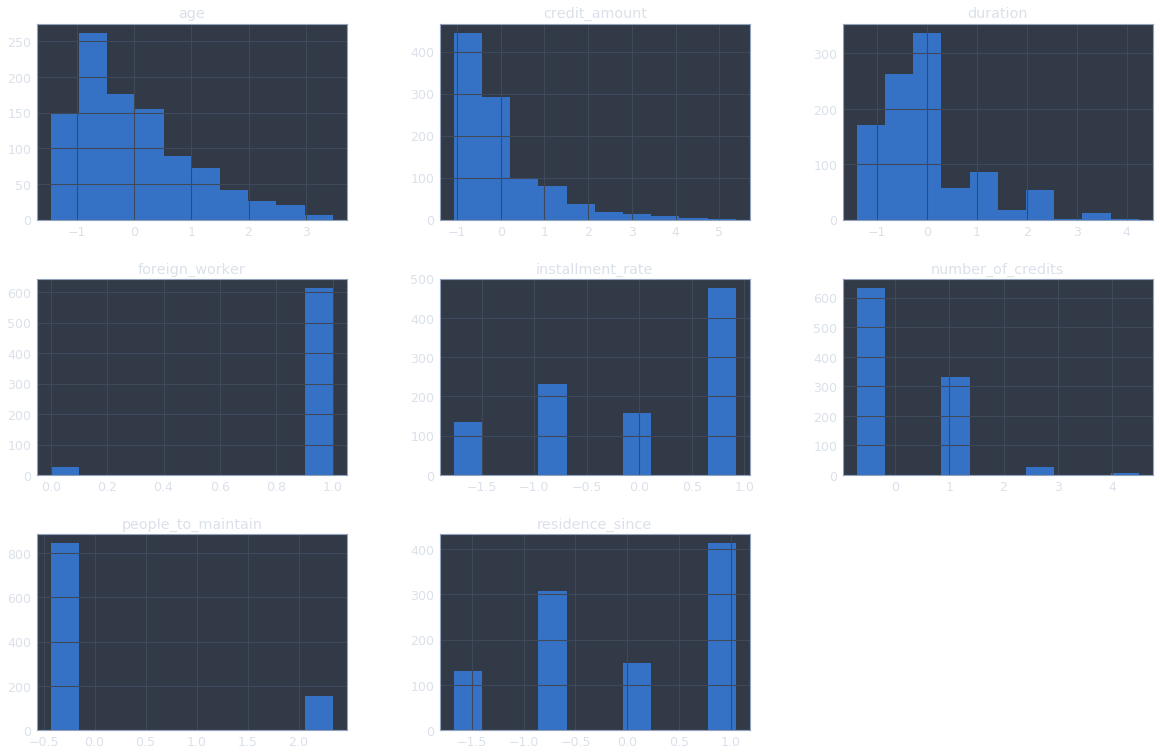

In [125]:
# Normalize all numerical attributes
def zscore(x):
    #assert isinstance(x,np.ndarray), "x must be a numpy array"
    return (x-np.mean(x)) / np.std(x)

df = df.apply(lambda x: zscore(x) if x.dtype == 'int64' else x)
df.hist(figsize = (20,13))

#### 2.1.2 Categorical

In [126]:
# Feature representation

print("Unique categorical values:")
for att in df.select_dtypes(include=[object]):
    print(att,":", df[att].unique())
    
# We will have to represent features differently 

Unique categorical values:
account_status : ['A14' 'A12' 'A13' 'A11']
credit_history : ['A32' 'A33' 'A34' 'A30' 'A31']
purpose : [nan 'A46' 'A40' 'A43' 'A41' 'A42' 'A49' 'A410' 'A45' 'A48' 'A44']
savings_account : ['A63' 'A65' 'A61' 'A64' 'A62']
employment_since : [nan 'A73' 'A74' 'A75' 'A72' 'A71']
personal_status_sex : ['A93' 'A94' 'A92' 'A91']
guarantors : ['A101' 'A102' 'A103']
property : ['A123' 'A124' 'A121' 'A122']
other_installment_plans : ['A143' 'A141' 'A142']
housing : ['A152' 'A153' 'A151']
job : ['A173' nan 'A174' 'A172' 'A171']
phone : ['A191' 'A192']


In [127]:
# print(f'old categorical variables: {categorical} \n')
# 1-hot encoding for the categorical variables
df_one_hot = pd.get_dummies(df, columns=categorical)
# print('new 1-hot-encoded variables: {}'.format(list(df_one_hot.columns)))
# we get rid of the redundant columns:
# df_one_hot.drop(labels=[''], axis=1, inplace=True)

# Concatenate numerical and categorical data
df = pd.concat([data[numerical], df_one_hot], axis = 1)
df.head()

,duration,credit_amount,installment_rate,residence_since,age,number_of_credits,people_to_maintain,duration,credit_amount,installment_rate,...,other_installment_plans_A143,housing_A151,housing_A152,housing_A153,job_A171,job_A172,job_A173,job_A174,phone_A191,phone_A192
0,1.252574,-0.344610,0.918477,1.046987,0.303788,-0.704926,-0.428290,1.252574,-0.344610,0.918477,...,1,0,1,0,0,0,1,0,1,0
1,-0.240857,-0.720320,0.918477,1.046987,2.238742,-0.704926,-0.428290,-0.240857,-0.720320,0.918477,...,1,0,0,1,0,0,0,0,1,0
2,0.256953,-0.823818,0.918477,0.140505,0.215835,-0.704926,2.334869,0.256953,-0.823818,0.918477,...,0,0,0,1,0,0,0,0,1,0
3,-0.489762,-0.635608,0.918477,0.140505,-0.223927,1.027079,-0.428290,-0.489762,-0.635608,0.918477,...,0,0,1,0,0,0,1,0,1,0
4,0.256953,-0.618950,0.918477,0.140505,-0.135974,-0.704926,2.334869,0.256953,-0.618950,0.918477,...,1,0,1,0,0,0,1,0,0,1


### 2.2 Handling Missing Values

NaN in Pandas:
1. Nan != NaN (whereas None == None)  
2. When summing data, NaN values will be treated as zero.   
If the data are all NA, the result will be 0.  


We must distinguish betweeen nominal and ordinal data

In [128]:
print(f'Number of Missing Values:\n\n{df.isnull().sum()}')

Number of Missing Values:

duration                          0
credit_amount                     0
installment_rate                  0
residence_since                   0
age                               0
number_of_credits                 0
people_to_maintain                0
duration                          0
credit_amount                     0
installment_rate                  0
residence_since                   0
age                               0
number_of_credits                 0
people_to_maintain                0
foreign_worker                  360
account_status_A11                0
account_status_A12                0
account_status_A13                0
account_status_A14                0
credit_history_A30                0
credit_history_A31                0
credit_history_A32                0
credit_history_A33                0
credit_history_A34                0
purpose_A40                       0
purpose_A41                       0
purpose_A410                      0
p

### 2.3 Feature Selection